In [6]:
# Import the libraries that we're going to use
#from nltk import casual_tokenize, word_tokenize, sent_tokenize
#from nltk.stem import PorterStemmer
#from nltk.corpus import stopwords

from collections import Counter
import string
import re

#from gensim.models.ldamodel import LdaModel
#from gensim import corpora

from pycorenlp import StanfordCoreNLP

In [7]:
import pandas as pd
import numpy as np

In [8]:
import matplotlib.pyplot as plt

In [9]:
NSF_data = pd.read_csv('./NSFdata.csv')


In [10]:
#print(NSF_data.head())
#print(NSF_data.award_instrument.unique())
#print(NSF_data.directorate_longname.unique())
states = NSF_data.state_code.unique()
#len(NSF_data.award_id.unique())/NSF_data.shape[0]

In [11]:
#check for missing values - prints the percentage of missing values per column
print(100*(round((NSF_data.isnull().sum())/(NSF_data.shape[0]), 2)))

list(NSF_data)

Unnamed: 0                0.0
award_title               0.0
award_effective_date      0.0
award_expiration_date     0.0
award_amount              0.0
award_instrument          0.0
organization_code         0.0
directorate_longname      0.0
division_longname         0.0
org_program_officer      26.0
abstract_text             1.0
minamd_letter_date        0.0
maxamd_letter_date        0.0
award_id                  0.0
first_name                0.0
last_name                 0.0
email                     3.0
start_date                0.0
role_code                 0.0
institution               0.0
city_name                 0.0
zipcode                   0.0
phonenumber               3.0
street_address            3.0
country                   0.0
state                     0.0
state_code                0.0
program_code             10.0
program_name             10.0
dtype: float64


['Unnamed: 0',
 'award_title',
 'award_effective_date',
 'award_expiration_date',
 'award_amount',
 'award_instrument',
 'organization_code',
 'directorate_longname',
 'division_longname',
 'org_program_officer',
 'abstract_text',
 'minamd_letter_date',
 'maxamd_letter_date',
 'award_id',
 'first_name',
 'last_name',
 'email',
 'start_date',
 'role_code',
 'institution',
 'city_name',
 'zipcode',
 'phonenumber',
 'street_address',
 'country',
 'state',
 'state_code',
 'program_code',
 'program_name']

In [12]:
#removing rows that are not interesting for our purposes.
subset = [
 'award_title',
 'award_effective_date',
# 'award_expiration_date',
 'award_amount',
 'award_instrument',
# 'organization_code',
 'directorate_longname',
# 'division_longname',
# 'org_program_officer',
 'abstract_text',
# 'minamd_letter_date',
# 'maxamd_letter_date',
# 'award_id',
# 'first_name',
# 'last_name',
# 'email',
# 'start_date',
# 'role_code',
 'institution',
# 'city_name',
 'zipcode',
# 'phonenumber',
# 'street_address',
 'country',
 'state',
 'state_code',
# 'program_code',
# 'program_name'
]
NSF_data = NSF_data[subset]

In [13]:
#removing rows with missing data
NSF_data = NSF_data.dropna()


In [14]:
list(NSF_data)

['award_title',
 'award_effective_date',
 'award_amount',
 'award_instrument',
 'directorate_longname',
 'abstract_text',
 'institution',
 'zipcode',
 'country',
 'state',
 'state_code']

In [15]:
#verifying that there are no missing values, and checking how many rows there are
print(100*(round((NSF_data.isnull().sum())/(NSF_data.shape[0]), 20)))
NSF_data.shape

award_title             0.0
award_effective_date    0.0
award_amount            0.0
award_instrument        0.0
directorate_longname    0.0
abstract_text           0.0
institution             0.0
zipcode                 0.0
country                 0.0
state                   0.0
state_code              0.0
dtype: float64


(136836, 11)

In [16]:
#count number of words in each abstract
def count_words(txt):
    tmp = txt.split()
    return len(tmp)

NSF_data["abstract_lengths"] = NSF_data.abstract_text.apply(count_words)
#remove abstracts with less than 5 words. This is not necessary, and some abstracts with less than 5 words are legitimate
NSF_data = NSF_data[NSF_data['abstract_lengths'] > 5]

In [17]:
#Remove duplicate rows
NSF_data = NSF_data.drop_duplicates()

In [18]:
NSF_data.shape

(136657, 12)

In [19]:
NSF_data.abstract_lengths.mean()

337.2667481358437

In [21]:
NSF_data['award_effective_date'] = pd.to_datetime(NSF_data['award_effective_date'])

In [22]:
# create new cols for month and year
month = []
year = []
NSF_data['month'] = NSF_data.award_effective_date.map(lambda x: x.strftime('%m'))
NSF_data['year'] = NSF_data.award_effective_date.map(lambda x: x.strftime('%Y'))

In [23]:

# group by 
NSF_group = NSF_data[['year', 'month', 'abstract_lengths']].groupby(['year','month']).mean().reset_index()
NSF_group = NSF_group.rename(columns = {'abstract_lengths' : 'mean_abstracts_length'})


In [24]:
NSF_group['date'] = pd.to_datetime(NSF_group['year'] + " " + NSF_group['month'])

In [26]:
NSF_group.mean_abstracts_length.max()

563.0

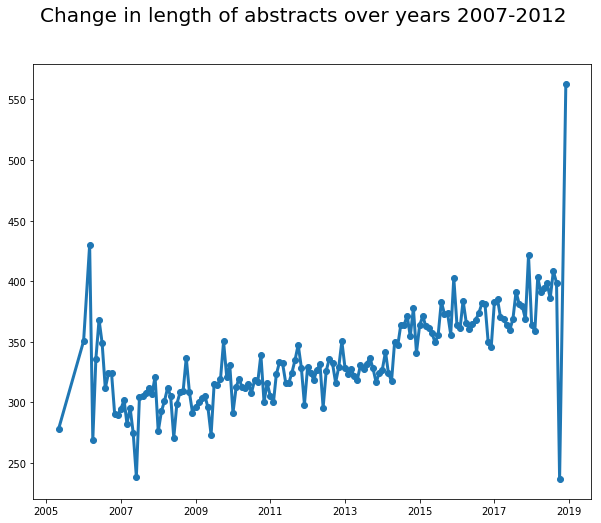

In [27]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Change in length of abstracts over years 2007-2012', fontsize=20)


plt.plot(NSF_group.date, 
         NSF_group.mean_abstracts_length, 
         lw = 3, marker = 'o') # main line



In [28]:
NSF_group2 = NSF_data[['year', 'month', 'abstract_text']].groupby(['year','month']).count().reset_index()
NSF_group2 = NSF_group2.rename(columns = {'abstract_text' : 'number_of_awards'})
#NSF_group2.head(20)

In [29]:
NSF_group2['date'] = pd.to_datetime(NSF_group2['year'] + " " + NSF_group2['month'])

5261


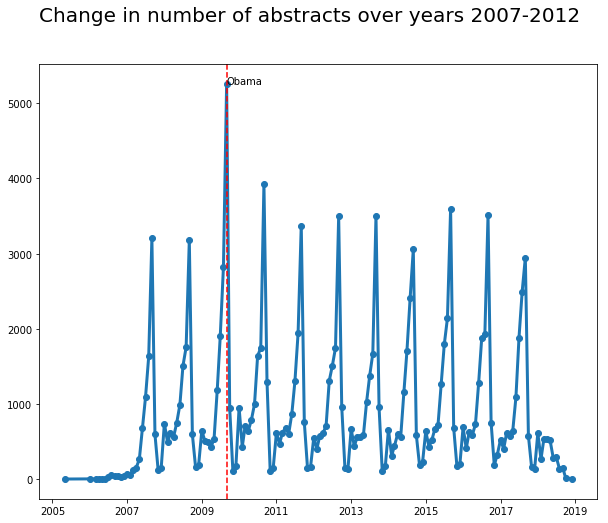

In [30]:
import matplotlib.dates as mdates
# import matplotlib.axis.Axis as axis

fig2 = plt.figure(figsize=(10, 8))
fig2.suptitle('Change in number of abstracts over years 2007-2012', fontsize=20)

obama_value = NSF_group2.number_of_awards.max()
print(obama_value)
obama_index = NSF_group2.number_of_awards.idxmax()

plt.plot(NSF_group2.date, 
         NSF_group2.number_of_awards, 
         lw = 3, marker = 'o') # main line

augment_x = mdates.date2num(NSF_group2.date[obama_index])
plt.annotate("Obama change to awards - increased #of awards", xy=(augment_x, obama_value), 
             xycoords='data')
plt.axvline(x = augment_x, color='r', linestyle='--') #add a horizontal line at 0)


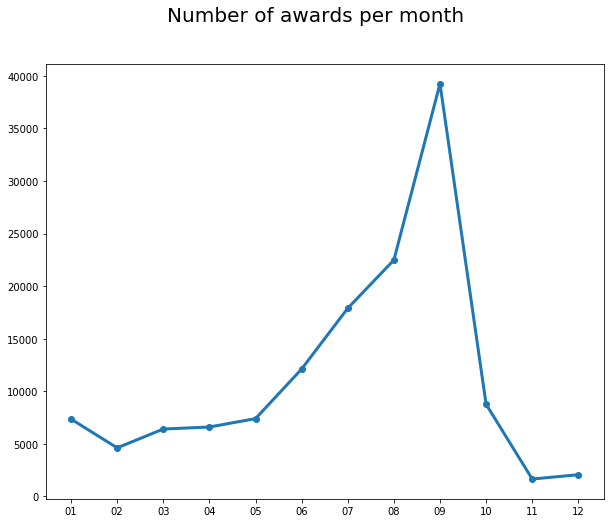

In [31]:
NSF_group3 = NSF_data[['month', 'abstract_text']].groupby(['month']).count().reset_index()
NSF_group3 = NSF_group3.rename(columns = {'abstract_text' : 'number_of_awards'})
NSF_group3.head(20)
NSF_group3
fig3 = plt.figure(figsize=(10, 8))
fig3.suptitle('Number of awards per month', fontsize=20)


plt.plot(NSF_group3.month, 
         NSF_group3.number_of_awards, 
         lw = 3, marker = 'o') # main line

In [33]:
import datetime as dt

indices = (NSF_group.date > dt.datetime(2007, 1, 1)) & (NSF_group.date < dt.datetime(2018, 1, 1))

In [34]:
#doing a smooth time trend for length of abstracts
import scipy as sp
x = NSF_group.index[indices]
y = NSF_group.mean_abstracts_length[indices]
#the polynomial will go up to degree=deg
p = sp.polyfit(x, y, deg=8)
y_ = sp.polyval(p, x)

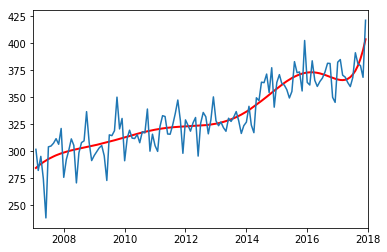

In [35]:
# plot smoothened data
plt.plot(NSF_group.date[indices], y_, color='r', linewidth=2)
plt.plot(NSF_group.date[indices], NSF_group.mean_abstracts_length[indices])
plt.xlim([dt.datetime(2007, 1, 1), dt.datetime(2018, 1, 1)])

plt.show()

In [36]:
#all words of all abstracts per year - done
#clean from stop words - done
#stemming and lemmatization - in progress
#count frequency of each word each year 
#- number of appearances of this word, - done
#- divided by the total number of words, should sum to 1)
#- name the column <year>_freq
#Combine all years by df = df<year>.merge(df<year-1>, on= 'word', how = 'outer')
#missing words should be set to 0.
#for each word, calculate the differences between its frequencies from one year to the other, maximum and minimum.
#plot the change in frequencies to the 3 words that had the biggest change in occurances throughout time.

In [38]:
#group by
#sum the column of abstracts into a long string

NSF_year = NSF_data[['year', 'abstract_text']].groupby(['year']).sum().reset_index()



In [39]:
NSF_year.head()

,year,abstract_text
0,2005,Abstract - Integration of Unstructured Text Do...
1,2006,Behavioral and neuroendocrine variation in mam...
2,2007,The objective of this collaborative research p...
3,2008,0700911&lt;br/&gt;Green&lt;br/&gt;&lt;br/&gt;T...
4,2009,Continental glaciers lowered global sea level ...


In [40]:
import nltk
import re
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#I took out 'not', 'n't' 
stopwords = [
    
    "i", "me", "my", "myself", "not", "n\'t",
    "we", "our", "ours", "ourselves", 
    "you", "your", "yours", "yourself", "yourselves", 
    "he", "him", "his", "himself", 
    "she", "her", "hers", "herself", "he/she", 
    "it", "its", "itself", 
    "they", "them", "their", "theirs", "themselves", 
    "what", "which", "who", "whom", 
    "this", "that", "these", "those", 
    "am", "is", "are", "was", "were", "be", "been", "being", 
    "have", "has", "had", "having", 
    "do", "does", "did", "doing", 
    "a", "an", "the", 
    "of", "at", "by", "for", "with", "about", 
    "between", "into", "through", 
    "during", "before", "after", 
    "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", 
    "again", "further", "then", "once", 
    "here", "there", 
    "and","lt", "gt", "br", "will", "research", "as", "project", "use","develop"
]

stopwords.extend([
    "abstract"
])

# def remove_stopwords(tokenized):
#     stop = set(stopwords)
#     stripped = [[word for word in sentence if word not in stop] for sentence in tokenized]
#     return [i for i in stripped if len(i) > 0]

def tokenize_and_stem(text):
    if not text:
        return []
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.RegexpTokenizer(r'((?<=[^\w\s])\w(?=[^\w\s])|(\W))+', gaps=True).tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token.lower())
    stems = [s for s in [stemmer.stem(t) for t in filtered_tokens] if s not in stopwords]
    #stems = " ".join(stems)
    
    return stems

In [42]:
from collections import Counter

NSF_year['word_count'] = NSF_year.abstract_text.apply(tokenize_and_stem).apply(Counter)
NSF_year.head()


,year,abstract_text,word_count
0,2005,Abstract - Integration of Unstructured Text Do...,"{'integr': 5, 'unstructur': 4, 'text': 5, 'doc..."
1,2006,Behavioral and neuroendocrine variation in mam...,"{'behavior': 78, 'neuroendocrin': 1, 'variat':..."
2,2007,The objective of this collaborative research p...,"{'object': 2205, 'collabor': 3740, 'investig':..."
3,2008,0700911&lt;br/&gt;Green&lt;br/&gt;&lt;br/&gt;T...,"{'green': 227, 'intern': 2967, 'fellowship': 4..."
4,2009,Continental glaciers lowered global sea level ...,"{'continent': 423, 'glacier': 315, 'lower': 86..."


In [77]:
NSF_year.to_csv('NSF_year_wordcount.csv', sep=',')